## 猫狗分类
模型：ResNet18 \
训练：autodl \
数据集：https://www.modelscope.cn/datasets/XCsunny/cat_vs_dog_class

In [1]:
# 加载数据
import torchvision.transforms as Transforms
import torchvision.datasets as Datasets
import torch.utils.data as Data

def train_val_data_process():
    ROOT_DIR = r'./root/autodl-tmp/data/cats_vs_dog/'
    
    transform = Transforms.Compose([
        Transforms.Resize((224,224)),
        Transforms.ToTensor(),
        Transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = Datasets.ImageFolder(
        root=ROOT_DIR + 'train',
        transform=transform
    )
    train_loader = Data.DataLoader(
        dataset=train_dataset,
        batch_size=256,
        shuffle=True,
        num_workers=8,
        pin_memory=True,          # 加速（如果用 GPU）
        drop_last=True            # 可选，避免小 batch 干扰 BN
    )
    
    val_dataset = Datasets.ImageFolder(
        root=ROOT_DIR + 'val',
        transform=transform
    )
    val_loader = Data.DataLoader(
        dataset=val_dataset,
        batch_size=256,
        shuffle=False,            # 验证一般不 shuffle
        num_workers=8,
        pin_memory=True
    )
    
    print(f"训练样本数: {len(train_dataset)} | 验证样本数: {len(val_dataset)}")
    return train_loader, val_loader

In [2]:
import torch
import torch.nn as nn

class Residual(nn.Module):
    def __init__(self, in_channels, num_channels, stride=1, use1x1conv=False):
        super(Residual, self).__init__()
        self.RELU = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=num_channels, 
            kernel_size=3, stride=stride, padding=1)
        self.conv2 = nn.Conv2d(in_channels=num_channels, out_channels=num_channels, 
            kernel_size=3, stride=1, padding=1)
        # 批量归一化
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        # 1x1卷积层
        if use1x1conv:
            self.conv3 = nn.Conv2d(in_channels=in_channels, out_channels=num_channels, 
                kernel_size=1, stride=stride)
        else:
            self.conv3 = None
        
    def forward(self, X):
        Y = self.RELU(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return self.RELU(Y)

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ResNet, self).__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, 
                kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
        self.b2 = nn.Sequential(
            Residual(in_channels=64, num_channels=64),
            Residual(in_channels=64, num_channels=64),
        )

        self.b3 = nn.Sequential(
            Residual(in_channels=64, num_channels=128, use1x1conv=True, stride=2),
            Residual(in_channels=128, num_channels=128)
        )

        self.b4 = nn.Sequential(
            Residual(in_channels=128, num_channels=256, use1x1conv=True, stride=2),
            Residual(in_channels=256, num_channels=256),
        )

        self.b5 = nn.Sequential(
            Residual(in_channels=256, num_channels=512, use1x1conv=True, stride=2),
            Residual(in_channels=512, num_channels=512),
        )

        self.b6 = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=num_classes)
        )
        
    def forward(self, X):
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.b6(X)
        return X
        
        
        

In [3]:
# 画图
import matplotlib.pyplot as plt

def matplot_train_process_data(train_process_data):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_process_data['epoch'], train_process_data['train_loss'], 'ro-',label='Train Loss')
    plt.plot(train_process_data['epoch'], train_process_data['val_loss'], 'bs-', label='Val Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Val Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_process_data['epoch'], train_process_data['train_acc'], 'ro-', label='Train Acc')
    plt.plot(train_process_data['epoch'], train_process_data['val_acc'], 'bs-', label='Val Acc')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train and Val Accuracy')
    plt.show()

训练样本数: 6000 | 验证样本数: 2000
当前设备： cuda
Epoch 1/20 - LR: 0.001
----------
Train loss: 0.8790 Train acc: 0.5377 | Val loss: 1.7343 Val acc: 0.5145
Epoch 2/20 - LR: 0.001
----------
Train loss: 0.6487 Train acc: 0.6231 | Val loss: 0.6837 Val acc: 0.6045
Epoch 3/20 - LR: 0.001
----------
Train loss: 0.6282 Train acc: 0.6454 | Val loss: 0.6482 Val acc: 0.6250
Epoch 4/20 - LR: 0.001
----------
Train loss: 0.6173 Train acc: 0.6612 | Val loss: 0.6068 Val acc: 0.6710
Epoch 5/20 - LR: 0.001
----------
Train loss: 0.5800 Train acc: 0.6994 | Val loss: 0.7011 Val acc: 0.5705
Epoch 6/20 - LR: 0.001
----------
Train loss: 0.5736 Train acc: 0.7050 | Val loss: 0.5657 Val acc: 0.7030
Epoch 7/20 - LR: 0.001
----------
Train loss: 0.5416 Train acc: 0.7240 | Val loss: 0.5449 Val acc: 0.7375
Epoch 8/20 - LR: 0.001
----------
Train loss: 0.5252 Train acc: 0.7412 | Val loss: 0.6035 Val acc: 0.6910
Epoch 9/20 - LR: 0.001
----------
Train loss: 0.4882 Train acc: 0.7626 | Val loss: 0.5824 Val acc: 0.7010
Epoch 10/

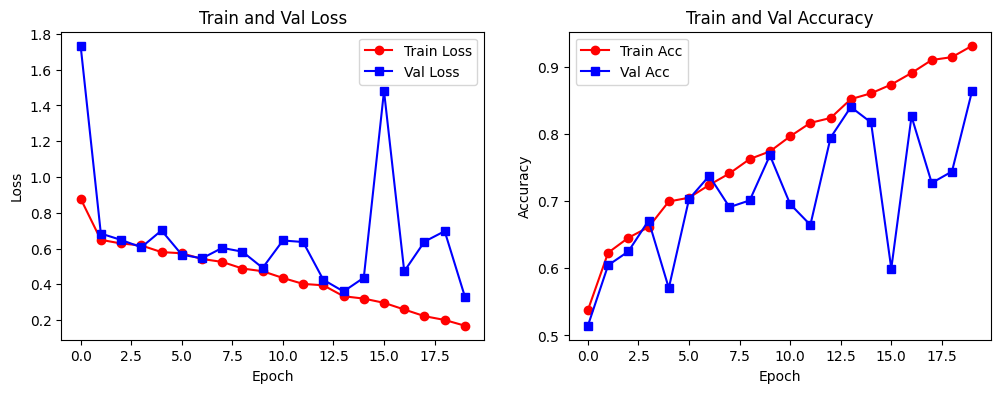

In [4]:
# 训练
import copy
import time
import torchvision.transforms as Transforms
import torchvision.datasets as Datasets
import torch.utils.data as Data
import pandas as pd
import torch

def train_model_process(model, train_loader, val_loader, num_epochs=5):
    # 加载模型
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("当前设备：", device)
    model = model.to(device)

    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    # 训练损失
    train_loss_all = []
    # 训练准确率
    train_acc_all = []
    # 验证损失
    val_loss_all = []
    # 验证准确率
    val_acc_all = []

    since = time.time()
    # 训练
    for epoch in range(num_epochs):
        
        print(f"Epoch {epoch+1}/{num_epochs} - LR: {optimizer.param_groups[0]['lr']}")
        print('-' * 10)
        
        train_loss = 0.0
        train_corrects = 0.0

        val_loss = 0.0
        val_corrects = 0.0

        train_num = 0
        val_num = 0

        # 训练
        for step, (b_x, b_y) in enumerate(train_loader):
            # 数据移动到设备
            b_x = b_x.to(device)
            b_y = b_y.to(device)

            train_num += b_x.size(0)

            # 模型训练
            model.train()
            outputs = model(b_x)
            # 计算损失
            loss = criterion(outputs, b_y)
            
            # 梯度清零，防止梯度叠加
            optimizer.zero_grad()
            # 反向传播
            loss.backward()
            # 更新参数
            optimizer.step()

            # 计算准确率
            pre_lab = torch.argmax(outputs, dim=1)
            train_corrects += torch.sum(pre_lab == b_y)
            # 计算损失
            train_loss += loss.item() * b_x.size(0)
            
            # 计算验证损失和准确率
        for step, (b_x, b_y) in enumerate(val_loader):
            b_x = b_x.to(device)
            b_y = b_y.to(device)

            val_num += b_x.size(0)

            # 模型验证
            model.eval()
            outputs = model(b_x)
            loss = criterion(outputs, b_y)

            # 计算验证损失
            val_loss += loss.item() * b_x.size(0)
            pre_lab = torch.argmax(outputs, dim=1)
            val_corrects += torch.sum(pre_lab == b_y)

        # 计算训练损失和准确率
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item() / train_num)
        val_loss_all.append(val_loss / val_num)
        val_acc_all.append(val_corrects.double().item() / val_num)

        print('Train loss: {:.4f} Train acc: {:.4f} | Val loss: {:.4f} Val acc: {:.4f}'
        .format(train_loss_all[-1], train_acc_all[-1], val_loss_all[-1], val_acc_all[-1]))

        # 保存最佳模型参数
    if val_acc_all[-1] > best_acc:
        best_acc = val_acc_all[-1]
        best_model_wts = copy.deepcopy(model.state_dict())
    

    time_elapsed = time.time() - since
    print(f"训练完成，用时 {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    
    # 保存最佳模型
    torch.save(best_model_wts, './root/autodl-tmp/model/dog_vs_cat_best_model.pth')

    train_process_data = pd.DataFrame({
        'epoch': range(num_epochs),
        'train_loss': train_loss_all,
        'train_acc': train_acc_all,
        'val_loss': val_loss_all,
        'val_acc': val_acc_all
    })
    return train_process_data
    

model = ResNet(3, 2)

train_loader, val_loader = train_val_data_process()
train_process_data = train_model_process(model, train_loader, val_loader, num_epochs=20)

matplot_train_process_data(train_process_data)
    